In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from xgboost import XGBClassifier

In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import json

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
from google.colab import files
uploaded = files.upload()

Saving updated_X_recommend.pkl to updated_X_recommend.pkl
Saving updated_X_test.pkl to updated_X_test.pkl
Saving updated_X_train.pkl to updated_X_train.pkl
Saving updated_y_test.pkl to updated_y_test.pkl
Saving updated_y_train.pkl to updated_y_train.pkl


In [6]:
# Load the data
X_train = pd.read_pickle('updated_X_train.pkl')
y_train = pd.read_pickle('updated_y_train.pkl')
X_test = pd.read_pickle('updated_X_test.pkl')
y_test = pd.read_pickle('updated_y_test.pkl')
X_recommend = pd.read_pickle('updated_X_recommend.pkl')

In [7]:
X_train['time_signature'] = X_train['time_signature'].astype(int)
#y_train['time_signature'] = y_train['time_signature'].astype(int)
X_test['time_signature'] = X_test['time_signature'].astype(int)
#y_test['time_signature'] = y_test['time_signature'].astype(int)
X_recommend['time_signature'] = X_recommend['time_signature'].astype(int)

IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

In [8]:
X_recommend.info()

<class 'pandas.core.frame.DataFrame'>
Index: 624 entries, 0 to 573
Columns: 113 entries, duration_ms to genre_shimmer pop
dtypes: float64(113)
memory usage: 555.8 KB


In [9]:
X_train.head()

,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,genre_modern indie pop,genre_modern rock,genre_nashville indie,genre_new romantic,genre_nz folk,genre_permanent wave,genre_pop,genre_pop punk,genre_pop rock,genre_shimmer pop
5430,175093.0,0.143,0.2690,10.0,-17.614,1.0,0.0351,0.290,0.859000,0.152,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1349,141062.0,0.106,0.0202,8.0,-32.719,1.0,0.0430,0.799,0.769000,0.109,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1754,210253.0,0.417,0.6890,2.0,-8.302,0.0,0.1780,0.575,0.000000,0.496,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7103,333329.0,0.499,0.5830,9.0,-6.628,0.0,0.2100,0.227,0.000000,0.103,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4726,168854.0,0.828,0.3330,4.0,-10.351,0.0,0.0332,0.732,0.000526,0.117,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Since XGBoost is an ensemble algorithm comprised of decision trees which is a Tree-based algorithm, it is fairly insensitive to the scale of the features, thus we wont scale the features for this model.

### Hyperparameter Tuning

We will tune for:
- Step size shrinkage, must be in range [0,1] (eta)
- Maximum depth of a tree (max_depth)
- Minimum sum of instance weight needed in a child (min_child_weight)

In [10]:
# Check accuracy for each value for each hyperparameter in its range
# We will use GridSearchCV to automate this process

eta = [0.2, 0.3, 0.4, 0.5]
max_depth = [0.3, 0.5, 0.8, 1]
min_child_weight = [3, 4, 5, 8, 12, 16, 20]

#Convert to dictionary
hyperparameters = dict(eta=eta,
                      max_depth=max_depth,
                      min_child_weight=min_child_weight)

print(hyperparameters)

{'eta': [0.2, 0.3, 0.4, 0.5], 'max_depth': [0.3, 0.5, 0.8, 1], 'min_child_weight': [3, 4, 5, 8, 12, 16, 20]}


In [11]:
# estimator = ML model to be tested
# param_grid = dictionary of hyperparameters to be tested
# n_jobs = number of cores to be used in parallel, -1 means use all
# cv = number of cross validation set elements
# verbose = setting it to 2 will print updates to the terminal

best_model = GridSearchCV(estimator=XGBClassifier(),
                         param_grid=hyperparameters,
                         n_jobs=-1,
                         cv=10,
                         verbose=2)

# Fit the model
best_model = best_model.fit(X_train,y_train)

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
840 fits failed out of a total of 1120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
280 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_

In [12]:
eta = best_model.best_estimator_.get_params()['eta']
max_depth = best_model.best_estimator_.get_params()['max_depth']
min_child_weight = best_model.best_estimator_.get_params()['min_child_weight']

print(f'Best eta: {eta}')
print(f'Best max_depth: {max_depth}')
print(f'Best min_child_weight: {min_child_weight}')

Best eta: 0.2
Best max_depth: 1
Best min_child_weight: 3


## Model

In [13]:
# model
xg_boost = XGBClassifier(eta=eta,
                        max_depth=max_depth,
                        min_child_weight=min_child_weight)

# fit the model
xg_boost.fit(X_train, y_train)

# prediction
predictions = xg_boost.predict(X_test)

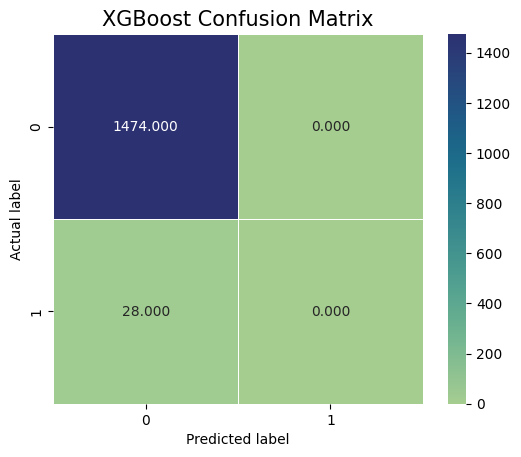

In [14]:
# Visualize confusiton matrix
cm = confusion_matrix(y_test, predictions)
plt.figure()
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'crest');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('XGBoost Confusion Matrix', size = 15);
plt.show()

In [15]:
precision_macro_average = precision_score(y_test, predictions, average='macro')
precision_weighted_average = precision_score(y_test, predictions, average='weighted')

recall_macro_average = recall_score(y_test, predictions, average='macro')
recall_weighted_average = recall_score(y_test, predictions, average='weighted')

f1_macro_average = f1_score(y_test, predictions, average='macro')
f1_weighted_average = f1_score(y_test, predictions, average='weighted')


print(f'Precision (macro average)--> {round(precision_macro_average*100, 2)}%')
print(f'Precision (weighted average)--> {round(precision_weighted_average*100, 2)}%')

print(f'Recall (macro average)--> {round(recall_macro_average*100, 2)}%')
print(f'Recall (weighted average)--> {round(recall_weighted_average*100, 2)}%')

print(f'F1 score (macro average)--> {round(f1_macro_average*100, 2)}%')
print(f'F1 score (weighted average)--> {round(f1_weighted_average*100, 2)}%')

Precision (macro average)--> 49.07%
Precision (weighted average)--> 96.31%
Recall (macro average)--> 50.0%
Recall (weighted average)--> 98.14%
F1 score (macro average)--> 49.53%
F1 score (weighted average)--> 97.21%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1474
           1       0.00      0.00      0.00        28

    accuracy                           0.98      1502
   macro avg       0.49      0.50      0.50      1502
weighted avg       0.96      0.98      0.97      1502



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
# File path on Google Drive
file_path = "/content/drive/MyDrive/year 29/Data Science /notebooks/spotify/model/f1_scores.json"

In [18]:
# Serialize f1 scores into a json file for later comparison between all models
model_name = "updated_xgboost"
entry = {"f1_macro_average":f1_macro_average, "f1_weighted_average":f1_weighted_average}


with open(file_path, "r") as file:
    data = json.load(file)
data[model_name] = entry
with open(file_path, "w") as file:
    json.dump(data, file, indent=4)